In [2]:
import torch
from model_triton import *

aa = torch.randn((2, 512, 3072), device="cuda")
#aa = aa.view(-1)
N = 100

t_gelu_fwd_jit = torch.compile(t_gelu_fwd)
t_gelu_fwd_jit(aa) # burn it

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        result = t_gelu_fwd_jit(aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

import time
t0 = time.time()
for _ in range(N):
    result = t_gelu_fwd_jit(aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'JIT total', total)

t0 = time.time()
for _ in range(N):
    result = t_gelu_fwd(aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'Naive total', total)

---------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
---------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  Torch-Compiled Region        68.03%       5.321ms        97.05%       7.591ms      75.910us       0.000us         0.00%       5.975ms      59.750us           100  
    triton_poi_fused_add_mul_pow_tanh_0        18.63%       1.457ms        26.69%       2.088ms      20.880us       5.382ms       100.00%       5.921ms      59.210us           100  
                         triton__0d1d2d         0.00%       0.000us         0.00%       0

STAGE:2025-01-22 09:12:06 69150:69150 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-22 09:12:06 69150:69150 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-22 09:12:06 69150:69150 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [31]:
def t_gelu_fwd(x):
    k = math.sqrt(2/math.pi)
    return 0.5 * x * (1 + torch.tanh(k * (x + 0.044715 * torch.pow(x,3))))

import triton
import triton.language as tl

# TODO T: explore using tl.erf for implementing this
@triton.jit
def tanh_k(x):
    return 2 * tl.sigmoid(2 * x) - 1

# TODO T: Do it in-place?
@triton.jit
def t_gelu_fwd_k(x_ptr,
               output_ptr,
               n_elements,
               BLOCK_SIZE: tl.constexpr,
               # NOTE: `constexpr` so it can be used as a shape value. <- TODO T: think about it
               ):
    pid = tl.program_id(axis=0)  
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    x = tl.load(x_ptr + offsets, mask=mask)
    k = tl.sqrt(2/math.pi) # TODO T: compute one as contant outside
    output = 0.5 * x * (1 + tanh_k(k * (x + 0.044715 * x * x * x)))
    tl.store(output_ptr + offsets, output, mask=mask)
    
def t_gelu_fwd_t(x: torch.Tensor):
    x_1d = x.view(-1)  # TODO T: do it in 3D instead
    output = torch.empty_like(x_1d)
    n_elements = output.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    t_gelu_fwd_k[grid](x_1d, output, n_elements, BLOCK_SIZE=1024)
    return output.reshape(x.shape)

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        result = t_gelu_fwd_t(aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

import time
t0 = time.time()
for _ in range(N):
    result = t_gelu_fwd_t(aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'total', total)

STAGE:2025-01-21 09:38:00 63031:63031 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
      t_gelu_fwd_k_0d1d2d         0.00%       0.000us         0.00%       0.000us       0.000us       5.357ms       100.00%       5.357ms      53.570us           100  
               aten::view         6.05%     261.000us         6.05%     261.000us       1.305us       0.000us         0.00%       0.000us       0.000us           200  
         aten::empty_like         5.01%     216.000us        63.98%       2.758ms      27.580us       0.000us         0.00%       0.000us       0.000us        

STAGE:2025-01-21 09:38:00 63031:63031 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-21 09:38:00 63031:63031 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [32]:
res1 = t_gelu_fwd_jit(aa)
print(f'res1', res1.shape, res1)
res2 = t_gelu_fwd_t(aa)
print(f'res2', res2.shape, res2)

res1 torch.Size([2, 512, 3072]) tensor([[[ 0.6789, -0.0586,  0.4063,  ...,  0.1945, -0.1517, -0.1170],
         [-0.0914,  1.1583, -0.1605,  ...,  1.2442, -0.1117, -0.1700],
         [-0.1394,  0.3071, -0.1177,  ..., -0.1408,  0.7008, -0.0734],
         ...,
         [-0.0880, -0.1635, -0.1700,  ...,  0.8145,  0.3563,  0.4697],
         [-0.1653, -0.1259,  0.5298,  ...,  0.8555,  0.2012,  0.2221],
         [ 1.5287, -0.1047, -0.0285,  ...,  0.0782,  1.2263,  1.0094]],

        [[-0.0317,  1.2300, -0.1502,  ..., -0.1697, -0.1401,  2.1861],
         [ 0.5059,  0.2916,  0.5464,  ..., -0.0897, -0.1530,  0.0278],
         [-0.0764, -0.0186, -0.1266,  ..., -0.0849, -0.1523, -0.0934],
         ...,
         [ 0.1284, -0.1610,  0.4450,  ..., -0.1230,  0.0881, -0.0063],
         [-0.0637, -0.0071, -0.1636,  ...,  0.4173,  0.8349, -0.1183],
         [ 0.1325, -0.0743, -0.0414,  ..., -0.0943, -0.1619, -0.1631]]],
       device='cuda:0')
res2 torch.Size([2, 512, 3072]) tensor([[[ 0.6789, -0.0586, 

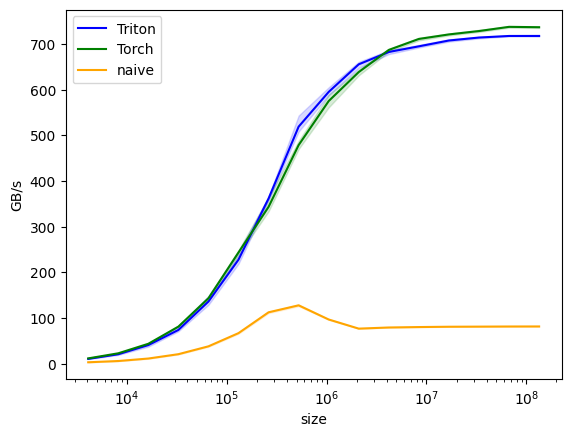

t_gelu_fwd:
           size      Triton       Torch       naive
0        4096.0   10.138615   11.294117    2.780090
1        8192.0   20.344371   22.423358    5.525180
2       16384.0   40.421054   43.267604   10.971428
3       32768.0   73.580836   80.842109   20.479999
4       65536.0  135.779009  142.883721   37.693251
5      131072.0  227.555555  243.326738   66.601628
6      262144.0  361.411758  343.120420  112.219181
7      524288.0  518.754611  478.364979  127.501947
8     1048576.0  594.880460  574.877170   96.459218
9     2097152.0  655.359969  638.337688   76.456546
10    4194304.0  682.370473  686.840182   78.949133
11    8388608.0  694.727912  710.898994   79.911798
12   16777216.0  707.501390  720.835903   80.582210
13   33554432.0  714.005113  728.219958   80.823414
14   67108864.0  717.424781  737.416810   81.109431
15  134217728.0  717.481014  736.596582   81.210072


In [33]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'naive'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch', 'naive'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='t_gelu_fwd',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: t_gelu_fwd_jit(x), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: t_gelu_fwd_t(x), quantiles=quantiles)
    if provider == 'naive':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: t_gelu_fwd(x), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)
benchmark.run(print_data=True, show_plots=True)

In [23]:
aa.numel()

3145728